In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import rasterio
import re
import tifffile
from keras.models import load_model
from keras.preprocessing.image import img_to_array

size = 256
# Load the pre-trained U-Net model
model = load_model('forest_detection_model_vgg16_unet_311223.h5')

def scaleStd(x):
    return (x - (np.nanmean(x) - np.nanstd(x) * 2)) / ((np.nanmean(x) + np.nanstd(x) * 2) - (np.nanmean(x) - np.nanstd(x) * 2))

def preprocess_input(image):
    # Assuming pixel values are in the range [0, 255]
    image = image / 255.0
    return image

def calculate_deforestation_percentage(image_paths, tile_size=size):
    num_years = len(image_paths)

    deforestation_percentages = []
    forest_percentages = []

    for i in range(num_years - 1):
        j = i + 1

        # Preprocess the images and split into tiles
        images_i = [preprocess_image(image_path, tile_size) for image_path in image_paths[i:i+2]]

        # Flatten the list of tiles
        tiles_i = [tile for tiles_per_image in images_i for tile in tiles_per_image]

        # Predict using the trained model for all tiles
        predictions_i = [model.predict(np.expand_dims(tile, axis=0)) for tile in tiles_i]

        # Calculate the percentage of deforestation for each tile
        deforestation_percentages_i = []
        for k in range(0, len(predictions_i), 2):
            # Calculate the sum of predictions for each pair of tiles
            sum_predictions_i = np.sum(predictions_i[k], axis=-1)
            sum_predictions_j = np.sum(predictions_i[k + 1], axis=-1)

            # Calculate the percentage of deforestation
            non_zero_mask = (sum_predictions_i + sum_predictions_j) != 0
            deforestation_percentage = np.zeros_like(sum_predictions_i)
            deforestation_percentage[non_zero_mask] = (
                np.abs(sum_predictions_j[non_zero_mask] - sum_predictions_i[non_zero_mask]) /
                (sum_predictions_i[non_zero_mask] + sum_predictions_j[non_zero_mask])
            ) * 100

            deforestation_percentages_i.append(np.nanmean(deforestation_percentage))

        # Calculate the overall percentage for this pair of years
        deforestation_percentages.append(np.nanmean(deforestation_percentages_i))

        # Calculate the percentage of remaining forest
        forest_percentage_i = 100 - np.nanmean(deforestation_percentages_i)
        forest_percentages.append(forest_percentage_i)

    return deforestation_percentages, forest_percentages

def visualize_deforestation(image_paths):
    num_images = len(image_paths)

    deforestation_percentages, forest_percentages = calculate_deforestation_percentage(image_paths)

    for i, image_path in enumerate(image_paths):
        # Load the original image using rasterio
        with rasterio.open(image_path) as src:
            r = src.read(3, masked=True)
            g = src.read(2, masked=True)
            b = src.read(1, masked=True)

        rStd = scaleStd(r)
        gStd = scaleStd(g)
        bStd = scaleStd(b)

        rgbStd = np.dstack((rStd, gStd, bStd)).copy()  # Make a copy
        # Commenting out the line that displays the image
        # axes[i].imshow(np.asarray(rgbStd, dtype=np.float32))  # Ensure the array is writable
        # axes[i].set_title(f"Original Image - {os.path.basename(image_path)}")

        # Print deforestation and forest percentages for each image
        if i > 0:
            year1 = extract_year_from_filename(os.path.basename(image_paths[i - 1]))
            year2 = extract_year_from_filename(os.path.basename(image_path))
            deforestation_text = f"Non-Forest Percentage - {year1} to {year2}: {deforestation_percentages[i - 1]:.2f}%"
            forest_text = f"Remaining Forest Percentage - {year1} to {year2}: {forest_percentages[i - 1]:.2f}%"
            print(deforestation_text)
            print(forest_text)


def extract_year_from_filename(filename):
    # Extract the last 4 digits from the filename
    match = re.search(r'\d{4}', filename)
    if match:
        return int(match.group())
    else:
        return None

def preprocess_image(image_path, tile_size=size):
    # Load and preprocess the image
    img = tifffile.imread(image_path)
    img_height, img_width, _ = img.shape

    # Split the image into tiles
    tiles = []
    for y in range(0, img_height, tile_size):
        for x in range(0, img_width, tile_size):
            tile = img[y:y+tile_size, x:x+tile_size, :]
            tiles.append(tile)

    # Pad tiles with zeros to the maximum width and height
    max_width = max(tile.shape[1] for tile in tiles)
    max_height = max(tile.shape[0] for tile in tiles)
    padded_tiles = [np.pad(tile, ((0, max_height - tile.shape[0]), (0, max_width - tile.shape[1]), (0, 0)), 'constant') for tile in tiles]

    # Preprocess each tile
    preprocessed_tiles = [preprocess_input(img_to_array(tile)) for tile in padded_tiles]

    return preprocessed_tiles

# Provide the directory containing satellite images for different years
image_directory = "testimage/sundarban"
image_paths = [os.path.join(image_directory, filename) for filename in os.listdir(image_directory) if filename.endswith(".TIF")]

# Visualize deforestation on the original images without showing the map
visualize_deforestation(image_paths)




1/1 [==============================] - 0s 227ms/step
Non-Forest Percentage - 2006 to 2007: 20.95%
Remaining Forest Percentage - 2006 to 2007: 79.05%
Non-Forest Percentage - 2007 to 2008: 16.48%
Remaining Forest Percentage - 2007 to 2008: 83.52%
Non-Forest Percentage - 2008 to 2009: 17.44%
Remaining Forest Percentage - 2008 to 2009: 82.56%
Non-Forest Percentage - 2009 to 2010: 16.63%
Remaining Forest Percentage - 2009 to 2010: 83.37%
Non-Forest Percentage - 2010 to 2011: 15.22%
Remaining Forest Percentage - 2010 to 2011: 84.78%
Non-Forest Percentage - 2011 to 2012: 15.03%
Remaining Forest Percentage - 2011 to 2012: 84.97%
Non-Forest Percentage - 2012 to 2013: 16.64%
Remaining Forest Percentage - 2012 to 2013: 83.36%
Non-Forest Percentage - 2013 to 2014: 24.21%
Remaining Forest Percentage - 2013 to 2014: 75.79%
Non-Forest Percentage - 2014 to 2015: 30.32%
Remaining Forest Percentage - 2014 to 2015: 69.68%
Non-Forest Percentage - 2015 to 2016: 23.13%
Remaining Forest Percentage - 2015 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import rasterio
import re
import tifffile
from keras.models import load_model
from keras.preprocessing.image import img_to_array

size = 256
# Load the pre-trained U-Net model
model = load_model('forest_detection_model_vgg16_unet_311223.h5')

def scaleStd(x):
    return (x - (np.nanmean(x) - np.nanstd(x) * 2)) / ((np.nanmean(x) + np.nanstd(x) * 2) - (np.nanmean(x) - np.nanstd(x) * 2))

def preprocess_input(image):
    # Assuming pixel values are in the range [0, 255]
    image = image / 255.0
    return image

def calculate_deforestation_percentage(image_paths, tile_size=size):
    num_years = len(image_paths)

    deforestation_percentages = []
    forest_percentages = []

    for i in range(num_years - 1):
        j = i + 1

        # Preprocess the images and split into tiles
        images_i = [preprocess_image(image_path, tile_size) for image_path in image_paths[i:i+2]]

        # Flatten the list of tiles
        tiles_i = [tile for tiles_per_image in images_i for tile in tiles_per_image]

        # Predict using the trained model for all tiles
        predictions_i = [model.predict(np.expand_dims(tile, axis=0)) for tile in tiles_i]

        # Calculate the percentage of deforestation for each tile
        deforestation_percentages_i = []
        for k in range(0, len(predictions_i), 2):
            # Calculate the sum of predictions for each pair of tiles
            sum_predictions_i = np.sum(predictions_i[k], axis=-1)
            sum_predictions_j = np.sum(predictions_i[k + 1], axis=-1)

            # Calculate the percentage of deforestation
            non_zero_mask = (sum_predictions_i + sum_predictions_j) != 0
            deforestation_percentage = np.zeros_like(sum_predictions_i)
            deforestation_percentage[non_zero_mask] = (
                np.abs(sum_predictions_j[non_zero_mask] - sum_predictions_i[non_zero_mask]) /
                (sum_predictions_i[non_zero_mask] + sum_predictions_j[non_zero_mask])
            ) * 100

            deforestation_percentages_i.append(np.nanmean(deforestation_percentage))

        # Calculate the overall percentage for this pair of years
        deforestation_percentages.append(np.nanmean(deforestation_percentages_i))

        # Calculate the percentage of remaining forest
        forest_percentage_i = 100 - np.nanmean(deforestation_percentages_i)
        forest_percentages.append(forest_percentage_i)

    return deforestation_percentages, forest_percentages

def visualize_deforestation(image_paths):
    num_images = len(image_paths)

    deforestation_percentages, forest_percentages = calculate_deforestation_percentage(image_paths)

    for i, image_path in enumerate(image_paths):
        # Load the original image using rasterio
        with rasterio.open(image_path) as src:
            r = src.read(3, masked=True)
            g = src.read(2, masked=True)
            b = src.read(1, masked=True)

        rStd = scaleStd(r)
        gStd = scaleStd(g)
        bStd = scaleStd(b)

        rgbStd = np.dstack((rStd, gStd, bStd)).copy()  # Make a copy
        # Commenting out the line that displays the image
        # axes[i].imshow(np.asarray(rgbStd, dtype=np.float32))  # Ensure the array is writable
        # axes[i].set_title(f"Original Image - {os.path.basename(image_path)}")

        # Print deforestation and forest percentages for each image
        if i > 0:
            year1 = extract_year_from_filename(os.path.basename(image_paths[i - 1]))
            year2 = extract_year_from_filename(os.path.basename(image_path))
            deforestation_text = f"Non-Forest Percentage - {year1} to {year2}: {deforestation_percentages[i - 1]:.2f}%"
            forest_text = f"Remaining Forest Percentage - {year1} to {year2}: {forest_percentages[i - 1]:.2f}%"
            print(deforestation_text)
            print(forest_text)


def extract_year_from_filename(filename):
    # Extract the last 4 digits from the filename
    match = re.search(r'\d{4}', filename)
    if match:
        return int(match.group())
    else:
        return None

def preprocess_image(image_path, tile_size=size):
    # Load and preprocess the image
    img = tifffile.imread(image_path)
    img_height, img_width, _ = img.shape

    # Split the image into tiles
    tiles = []
    for y in range(0, img_height, tile_size):
        for x in range(0, img_width, tile_size):
            tile = img[y:y+tile_size, x:x+tile_size, :]
            tiles.append(tile)

    # Pad tiles with zeros to the maximum width and height
    max_width = max(tile.shape[1] for tile in tiles)
    max_height = max(tile.shape[0] for tile in tiles)
    padded_tiles = [np.pad(tile, ((0, max_height - tile.shape[0]), (0, max_width - tile.shape[1]), (0, 0)), 'constant') for tile in tiles]

    # Preprocess each tile
    preprocessed_tiles = [preprocess_input(img_to_array(tile)) for tile in padded_tiles]

    return preprocessed_tiles

# Provide the directory containing satellite images for different years
image_directory = "testimage/modhu"
image_paths = [os.path.join(image_directory, filename) for filename in os.listdir(image_directory) if filename.endswith(".TIF")]

# Visualize deforestation on the original images without showing the map
visualize_deforestation(image_paths)

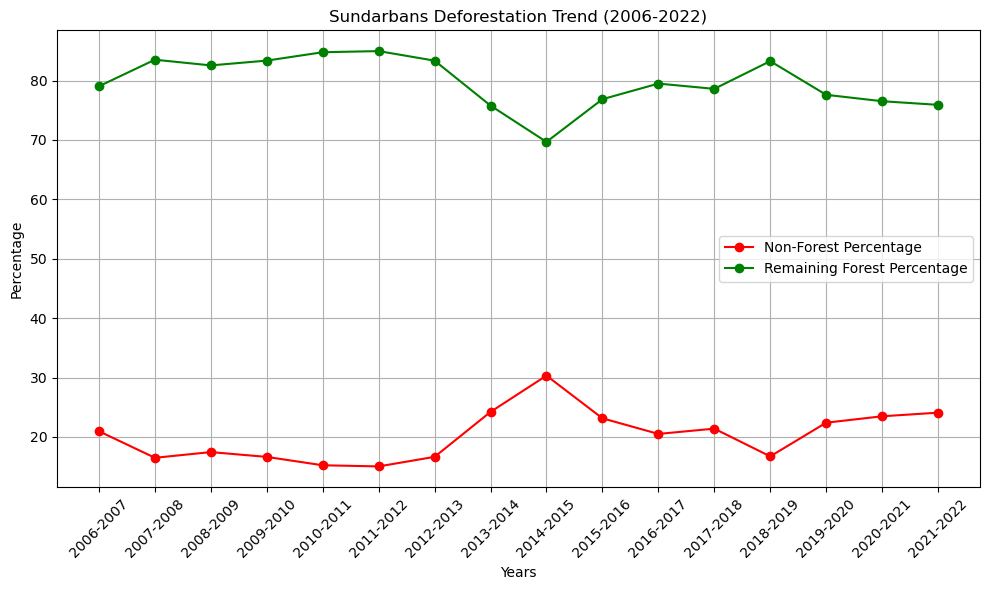

In [3]:
import matplotlib.pyplot as plt

years = ['2006-2007', '2007-2008', '2008-2009', '2009-2010', '2010-2011', '2011-2012', '2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022']

non_forest_percentage = [20.95, 16.48, 17.44, 16.63, 15.22, 15.03, 16.64, 24.21, 30.32, 23.13, 20.50, 21.39, 16.72, 22.39, 23.47, 24.08]
remaining_forest_percentage = [79.05, 83.52, 82.56, 83.37, 84.78, 84.97, 83.36, 75.79, 69.68, 76.87, 79.50, 78.61, 83.28, 77.61, 76.53, 75.92]

plt.figure(figsize=(10, 6))
plt.plot(years, non_forest_percentage, marker='o', label='Non-Forest Percentage', color='red')
plt.plot(years, remaining_forest_percentage, marker='o', label='Remaining Forest Percentage', color='green')

plt.title('Sundarbans Deforestation Trend (2006-2022)')
plt.xlabel('Years')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


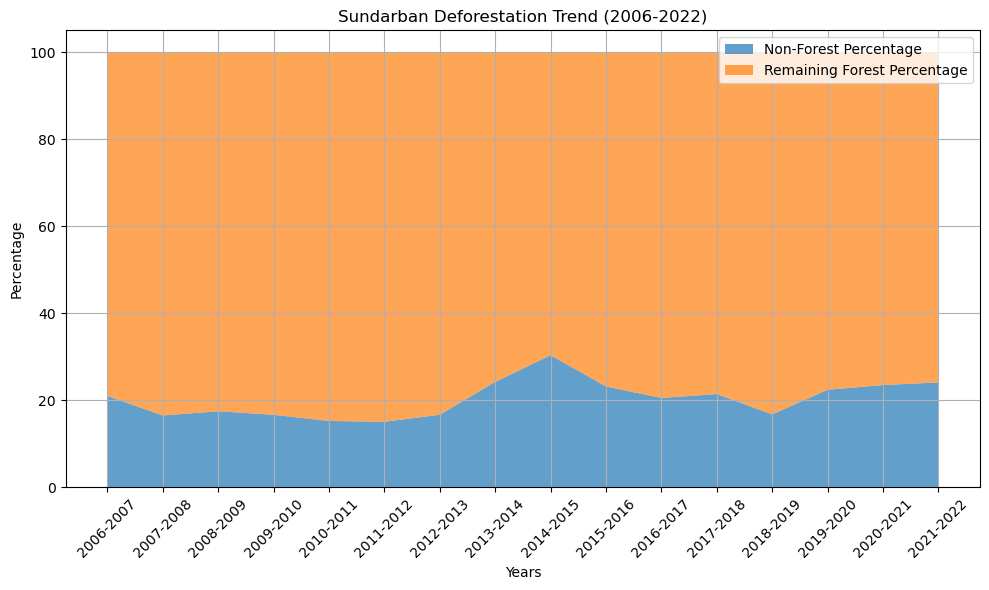

In [4]:
plt.figure(figsize=(10, 6))
plt.stackplot(years, non_forest_percentage, remaining_forest_percentage, labels=['Non-Forest Percentage', 'Remaining Forest Percentage'], alpha=0.7)

plt.title('Sundarban Deforestation Trend (2006-2022)')
plt.xlabel('Years')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


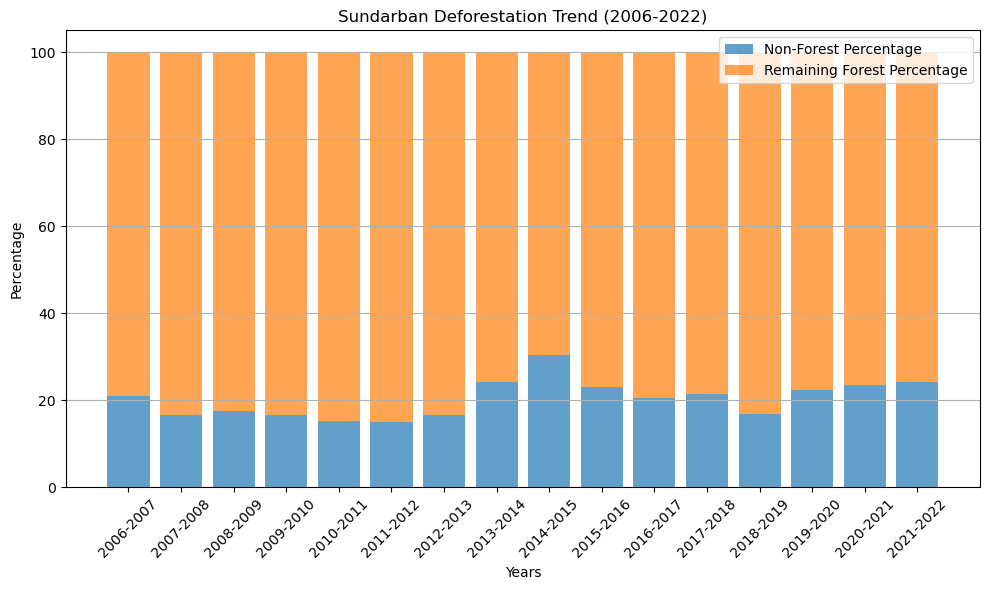

In [5]:
plt.figure(figsize=(10, 6))
plt.bar(years, non_forest_percentage, label='Non-Forest Percentage', alpha=0.7)
plt.bar(years, remaining_forest_percentage, bottom=non_forest_percentage, label='Remaining Forest Percentage', alpha=0.7)

plt.title('Modhupur Deforestation Trend (2006-2022)')
plt.xlabel('Years')
plt.ylabel('Percentage')
plt.legend()
plt.grid(axis='y')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


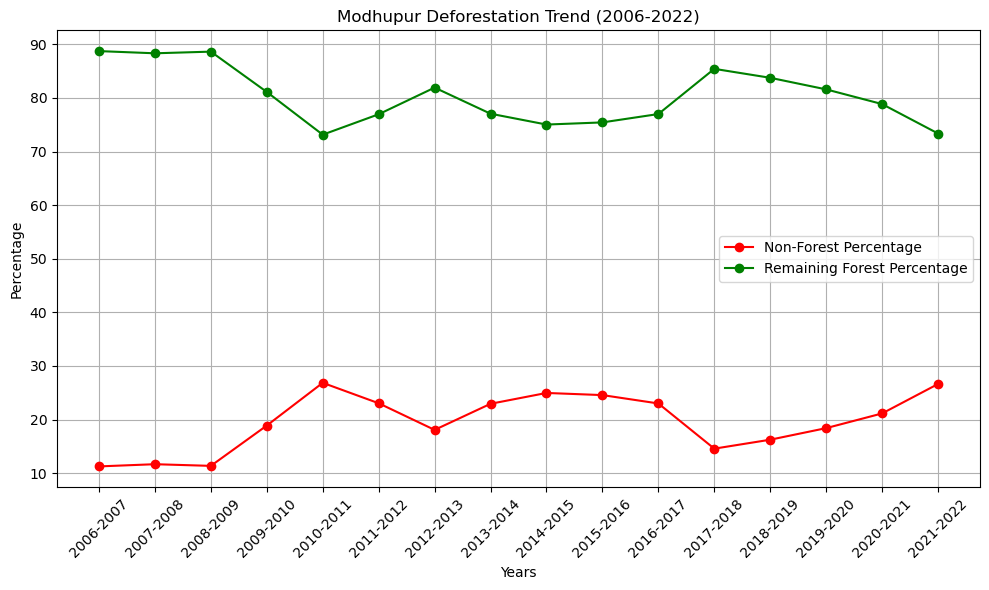

In [7]:
import matplotlib.pyplot as plt

years = ['2006-2007', '2007-2008', '2008-2009', '2009-2010', '2010-2011', '2011-2012', '2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022']

non_forest_percentage = [11.27, 11.68, 11.37, 18.89, 26.86, 23.05, 18.08, 22.95, 24.97, 24.57, 23.01, 14.58, 16.25, 18.41, 21.15, 26.64]
remaining_forest_percentage = [88.73, 88.32, 88.63, 81.11, 73.14, 76.95, 81.92, 77.05, 75.03, 75.43, 76.99, 85.42, 83.75, 81.59, 78.85, 73.36]

plt.figure(figsize=(10, 6))
plt.plot(years, non_forest_percentage, marker='o', label='Non-Forest Percentage', color='red')
plt.plot(years, remaining_forest_percentage, marker='o', label='Remaining Forest Percentage', color='green')

plt.title('Modhupur Deforestation Trend (2006-2022)')
plt.xlabel('Years')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


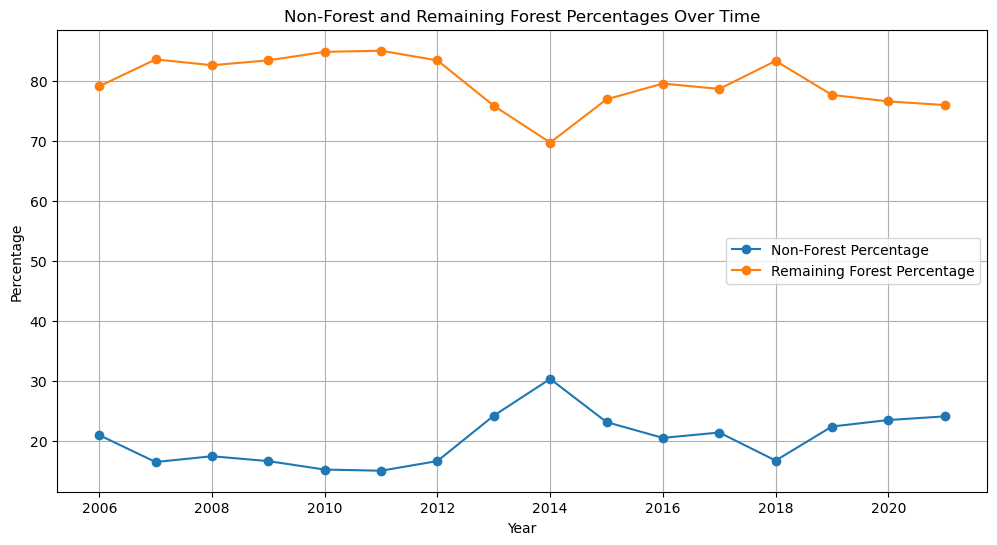

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
data = {
    'Year': ['2006-2007', '2007-2008', '2008-2009', '2009-2010', '2010-2011', '2011-2012', 
             '2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018', 
             '2018-2019', '2019-2020', '2020-2021', '2021-2022'],
    'Non-Forest Percentage': [20.95, 16.48, 17.44, 16.63, 15.22, 15.03, 16.64, 24.21, 
                              30.32, 23.13, 20.50, 21.39, 16.72, 22.39, 23.47, 24.08],
    'Remaining Forest Percentage': [79.05, 83.52, 82.56, 83.37, 84.78, 84.97, 83.36, 75.79, 
                                    69.68, 76.87, 79.50, 78.61, 83.28, 77.61, 76.53, 75.92]
}

df = pd.DataFrame(data)
# Split the year range and take the first year as the datetime
df['Year'] = df['Year'].apply(lambda x: pd.to_datetime(x.split('-')[0], format='%Y'))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['Non-Forest Percentage'], label='Non-Forest Percentage', marker='o')
plt.plot(df['Year'], df['Remaining Forest Percentage'], label='Remaining Forest Percentage', marker='o')
plt.title('Non-Forest and Remaining Forest Percentages Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\u2277809\AppData\Local\Temp\ipykernel_29440\3082867418.py:31: FutureWarning: The frame.append method is deprecated and will be removed from

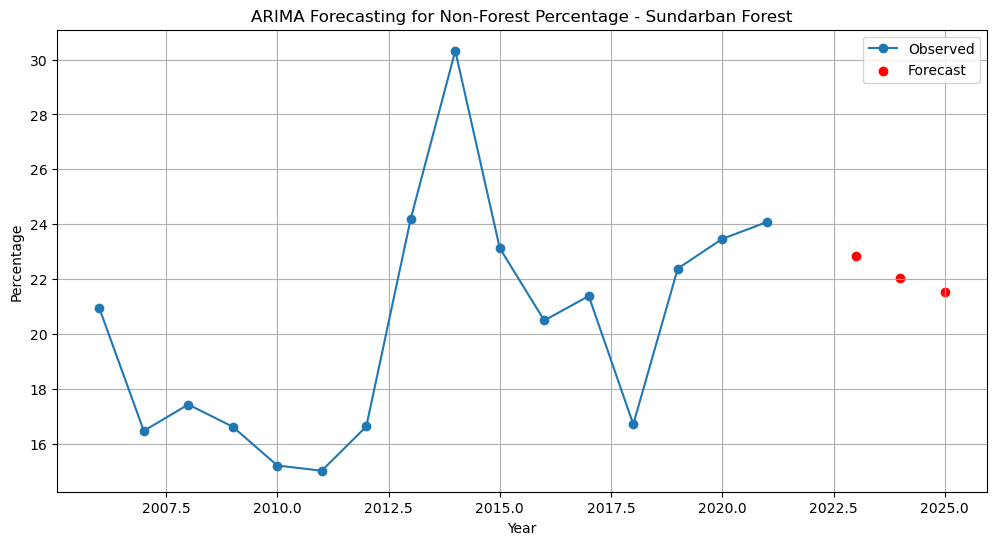

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load the data
data = {
    'Year': ['2006-2007', '2007-2008', '2008-2009', '2009-2010', '2010-2011', '2011-2012',
             '2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018',
             '2018-2019', '2019-2020', '2020-2021', '2021-2022'],
    'Non-Forest Percentage': [20.95, 16.48, 17.44, 16.63, 15.22, 15.03, 16.64, 24.21,
                              30.32, 23.13, 20.50, 21.39, 16.72, 22.39, 23.47, 24.08],
    'Remaining Forest Percentage': [79.05, 83.52, 82.56, 83.37, 84.78, 84.97, 83.36, 75.79,
                                    69.68, 76.87, 79.50, 78.61, 83.28, 77.61, 76.53, 75.92]
}

df = pd.DataFrame(data)
df['Year'] = df['Year'].apply(lambda x: int(x.split('-')[0]))
df.set_index('Year', inplace=True)

# Model fitting
model = ARIMA(df['Non-Forest Percentage'], order=(1, 1, 1))  # Example order, you may need to adjust
results = model.fit()

# Forecasting for the years 2023 and 2024
future_years = [2023, 2024, 2025]
forecast_values = results.get_forecast(steps=len(future_years)).predicted_mean

# Extend the time index for the forecasted years
df_forecast = df.copy()
df_forecast = df_forecast.append(pd.DataFrame(index=future_years))  # Extend the time index for the forecasted years
df_forecast.loc[future_years, 'Non-Forest Percentage'] = forecast_values

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_forecast.index, df_forecast['Non-Forest Percentage'], label='Observed', marker='o')
plt.scatter(future_years, forecast_values, color='red', label='Forecast', marker='o')
plt.title('ARIMA Forecasting for Non-Forest Percentage - Sundarban Forest')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.show()


ADF Statistic: -1.7851179954018719
p-value: 0.387874824106441
Critical Values: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}
Taking difference to achieve stationarity.


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\u2277809\AppData\Local\Temp\ipykernel_29440\4175800141.py:45: FutureWarning: The frame.append method is deprecated and will be removed from

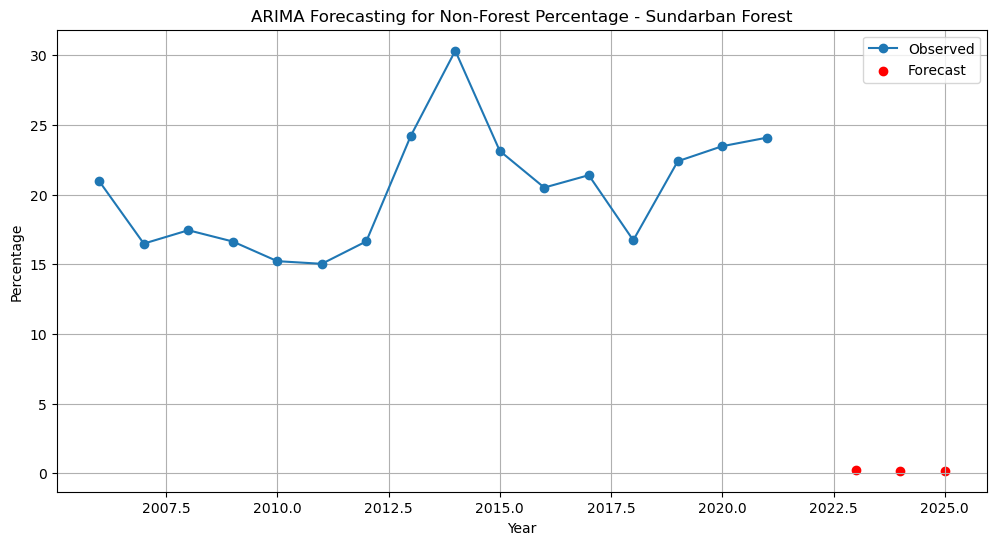

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Load the data
data = {
    'Year': ['2006-2007', '2007-2008', '2008-2009', '2009-2010', '2010-2011', '2011-2012',
             '2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018',
             '2018-2019', '2019-2020', '2020-2021', '2021-2022'],
    'Non-Forest Percentage': [20.95, 16.48, 17.44, 16.63, 15.22, 15.03, 16.64, 24.21,
                              30.32, 23.13, 20.50, 21.39, 16.72, 22.39, 23.47, 24.08],
    'Remaining Forest Percentage': [79.05, 83.52, 82.56, 83.37, 84.78, 84.97, 83.36, 75.79,
                                    69.68, 76.87, 79.50, 78.61, 83.28, 77.61, 76.53, 75.92]
}

df = pd.DataFrame(data)
df['Year'] = df['Year'].apply(lambda x: int(x.split('-')[0]))
df.set_index('Year', inplace=True)

# Stationarity testing using Augmented Dickey-Fuller test
result = adfuller(df['Non-Forest Percentage'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# If the data is not stationary, take the difference
if result[1] > 0.05:
    df_diff = df.diff().dropna()
    print('Taking difference to achieve stationarity.')
else:
    df_diff = df.copy()

# Model fitting
model = ARIMA(df_diff['Non-Forest Percentage'], order=(1, 1, 1))  # Example order, you may need to adjust
results = model.fit()

# Forecasting for the years 2023 and 2024
future_years = [2023, 2024, 2025]
forecast_values = results.get_forecast(steps=len(future_years)).predicted_mean

# Extend the time index for the forecasted years
df_forecast = df.copy()
df_forecast = df_forecast.append(pd.DataFrame(index=future_years))  # Extend the time index for the forecasted years
df_forecast.loc[future_years, 'Non-Forest Percentage'] = forecast_values

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_forecast.index, df_forecast['Non-Forest Percentage'], label='Observed', marker='o')
plt.scatter(future_years, forecast_values, color='red', label='Forecast', marker='o')
plt.title('ARIMA Forecasting for Non-Forest Percentage - Sundarban Forest')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.show()


ADF Statistic: -1.7851179954018719
p-value: 0.387874824106441
Critical Values: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}
Taking difference to achieve stationarity.


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\u2277809\AppData\Local\Temp\ipykernel_29440\4175800141.py:45: FutureWarning: The frame.append method is deprecated and will be removed from

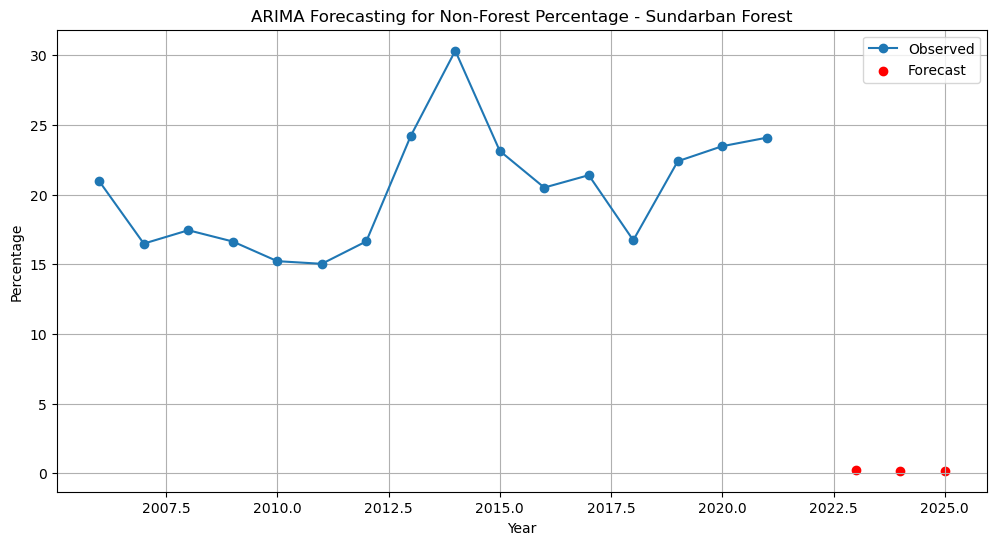

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Load the data
data = {
    'Year': ['2006-2007', '2007-2008', '2008-2009', '2009-2010', '2010-2011', '2011-2012',
             '2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018',
             '2018-2019', '2019-2020', '2020-2021', '2021-2022'],
    'Non-Forest Percentage': [20.95, 16.48, 17.44, 16.63, 15.22, 15.03, 16.64, 24.21,
                              30.32, 23.13, 20.50, 21.39, 16.72, 22.39, 23.47, 24.08],
    'Remaining Forest Percentage': [79.05, 83.52, 82.56, 83.37, 84.78, 84.97, 83.36, 75.79,
                                    69.68, 76.87, 79.50, 78.61, 83.28, 77.61, 76.53, 75.92]
}

df = pd.DataFrame(data)
df['Year'] = df['Year'].apply(lambda x: int(x.split('-')[0]))
df.set_index('Year', inplace=True)

# Stationarity testing using Augmented Dickey-Fuller test
result = adfuller(df['Non-Forest Percentage'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# If the data is not stationary, take the difference
if result[1] > 0.05:
    df_diff = df.diff().dropna()
    print('Taking difference to achieve stationarity.')
else:
    df_diff = df.copy()

# Model fitting
model = ARIMA(df_diff['Non-Forest Percentage'], order=(1, 1, 1))  # Example order, you may need to adjust
results = model.fit()

# Forecasting for the years 2023 and 2024
future_years = [2023, 2024, 2025]
forecast_values = results.get_forecast(steps=len(future_years)).predicted_mean

# Extend the time index for the forecasted years
df_forecast = df.copy()
df_forecast = df_forecast.append(pd.DataFrame(index=future_years))  # Extend the time index for the forecasted years
df_forecast.loc[future_years, 'Non-Forest Percentage'] = forecast_values

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_forecast.index, df_forecast['Non-Forest Percentage'], label='Observed', marker='o')
plt.scatter(future_years, forecast_values, color='red', label='Forecast', marker='o')
plt.title('ARIMA Forecasting for Non-Forest Percentage - Sundarban Forest')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.show()


ADF Statistic: -1.7851179954018719
p-value: 0.387874824106441
Critical Values: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}
Taking difference to achieve stationarity.


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\u2277809\AppData\Local\Temp\ipykernel_29440\455731954.py:45: FutureWarning: The frame.append method is deprecated and will be removed from 

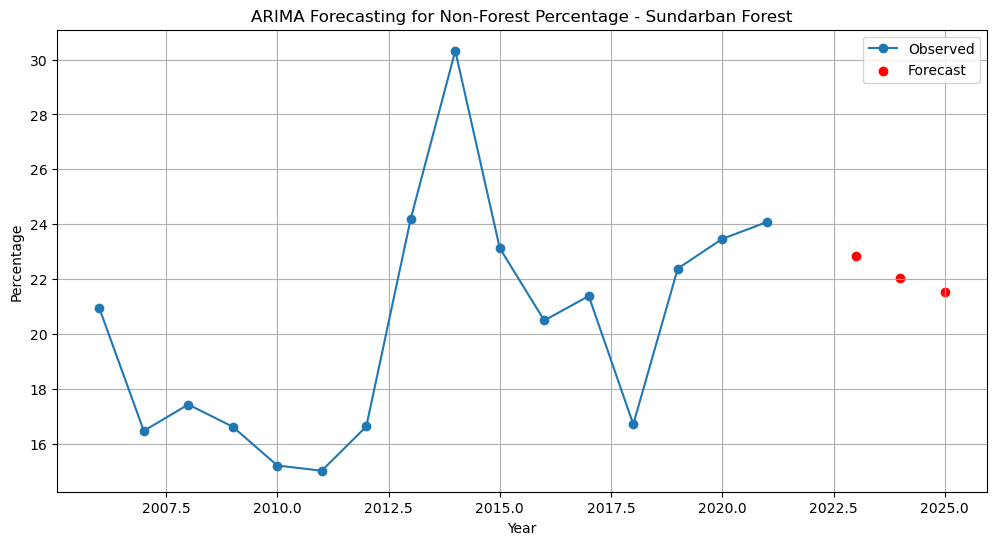

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Load the data
data = {
    'Year': ['2006-2007', '2007-2008', '2008-2009', '2009-2010', '2010-2011', '2011-2012',
             '2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018',
             '2018-2019', '2019-2020', '2020-2021', '2021-2022'],
    'Non-Forest Percentage': [20.95, 16.48, 17.44, 16.63, 15.22, 15.03, 16.64, 24.21,
                              30.32, 23.13, 20.50, 21.39, 16.72, 22.39, 23.47, 24.08],
    'Remaining Forest Percentage': [79.05, 83.52, 82.56, 83.37, 84.78, 84.97, 83.36, 75.79,
                                    69.68, 76.87, 79.50, 78.61, 83.28, 77.61, 76.53, 75.92]
}

df = pd.DataFrame(data)
df['Year'] = df['Year'].apply(lambda x: int(x.split('-')[0]))
df.set_index('Year', inplace=True)

# Stationarity testing using Augmented Dickey-Fuller test
result = adfuller(df['Non-Forest Percentage'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# If the data is not stationary, take the difference
if result[1] > 0.05:
    df_diff = df.diff().dropna()
    print('Taking difference to achieve stationarity.')
else:
    df_diff = df.copy()

# Model fitting
model = ARIMA(df['Non-Forest Percentage'], order=(1, 1, 1))  # Example order, you may need to adjust
results = model.fit()

# Forecasting for the years 2023, 2024, and 2025
future_years = [2023, 2024, 2025]
forecast_values = results.get_forecast(steps=len(future_years)).predicted_mean

# Extend the time index for the forecasted years
df_forecast = df.copy()
df_forecast = df_forecast.append(pd.DataFrame(index=future_years))  # Extend the time index for the forecasted years
df_forecast.loc[future_years, 'Non-Forest Percentage'] = forecast_values

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_forecast.index, df_forecast['Non-Forest Percentage'], label='Observed', marker='o')
plt.scatter(future_years, forecast_values, color='red', label='Forecast', marker='o')
plt.title('ARIMA Forecasting for Non-Forest Percentage - Sundarban Forest')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.show()


ADF Statistic: -1.7851179954018719
p-value: 0.387874824106441
Critical Values: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}
Taking difference to achieve stationarity.


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\u2277809\AppData\Local\Temp\ipykernel_29440\884612925.py:45: FutureWarning: The frame.append method is deprecated and will be removed from 

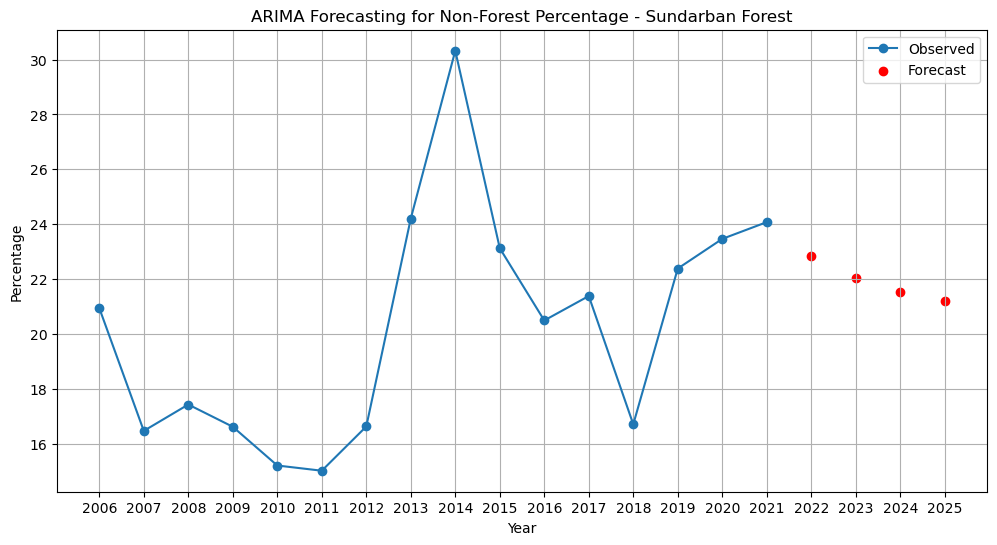

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Load the data
data = {
    'Year': ['2006-2007', '2007-2008', '2008-2009', '2009-2010', '2010-2011', '2011-2012',
             '2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018',
             '2018-2019', '2019-2020', '2020-2021', '2021-2022'],
    'Non-Forest Percentage': [20.95, 16.48, 17.44, 16.63, 15.22, 15.03, 16.64, 24.21,
                              30.32, 23.13, 20.50, 21.39, 16.72, 22.39, 23.47, 24.08],
    'Remaining Forest Percentage': [79.05, 83.52, 82.56, 83.37, 84.78, 84.97, 83.36, 75.79,
                                    69.68, 76.87, 79.50, 78.61, 83.28, 77.61, 76.53, 75.92]
}

df = pd.DataFrame(data)
df['Year'] = df['Year'].apply(lambda x: int(x.split('-')[0]))
df.set_index('Year', inplace=True)

# Stationarity testing using Augmented Dickey-Fuller test
result = adfuller(df['Non-Forest Percentage'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# If the data is not stationary, take the difference
if result[1] > 0.05:
    df_diff = df.diff().dropna()
    print('Taking difference to achieve stationarity.')
else:
    df_diff = df.copy()

# Model fitting
model = ARIMA(df['Non-Forest Percentage'], order=(1, 1, 1))  # Example order, you may need to adjust
results = model.fit()

# Forecasting for the years 2023, 2024, and 2025
future_years = [2022, 2023, 2024, 2025]
forecast_values = results.get_forecast(steps=len(future_years)).predicted_mean

# Extend the time index for the forecasted years
df_forecast = df.copy()
df_forecast = df_forecast.append(pd.DataFrame(index=future_years))  # Extend the time index for the forecasted years
df_forecast.loc[future_years, 'Non-Forest Percentage'] = forecast_values

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_forecast.index, df_forecast['Non-Forest Percentage'], label='Observed', marker='o')
plt.scatter(future_years, forecast_values, color='red', label='Forecast', marker='o')
plt.title('ARIMA Forecasting for Non-Forest Percentage - Sundarban Forest')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.xticks(df_forecast.index)  # Set x-axis ticks to match the index
plt.legend()
plt.grid(True)
plt.show()


ADF Statistic: -1.7851179954018705
p-value: 0.38787482410644164
Critical Values: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}
Taking difference to achieve stationarity.


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\u2277809\AppData\Local\Temp\ipykernel_29440\455305198.py:45: FutureWarning: The frame.append method is deprecated and will be removed from 

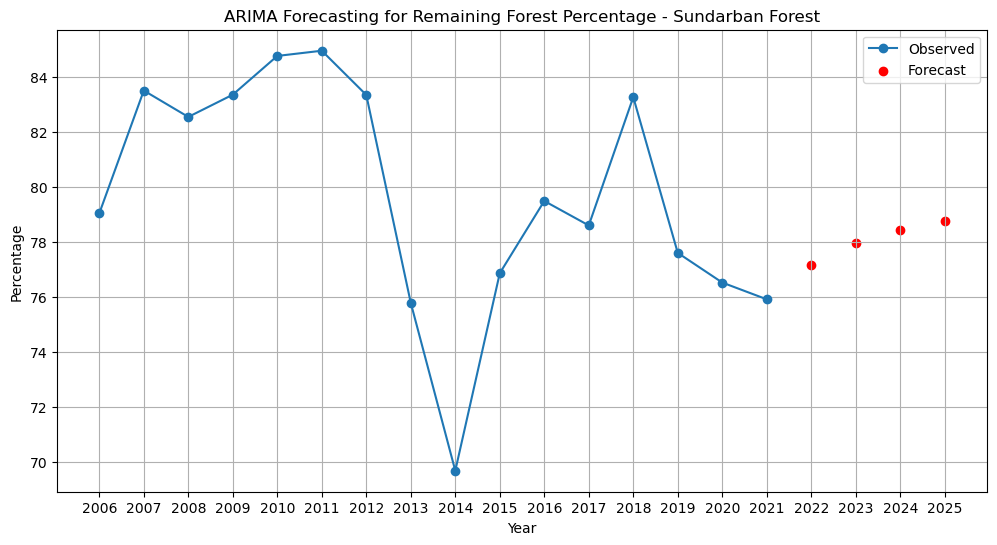

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Load the data
data = {
    'Year': ['2006-2007', '2007-2008', '2008-2009', '2009-2010', '2010-2011', '2011-2012',
             '2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018',
             '2018-2019', '2019-2020', '2020-2021', '2021-2022'],
    'Non-Forest Percentage': [20.95, 16.48, 17.44, 16.63, 15.22, 15.03, 16.64, 24.21,
                              30.32, 23.13, 20.50, 21.39, 16.72, 22.39, 23.47, 24.08],
    'Remaining Forest Percentage': [79.05, 83.52, 82.56, 83.37, 84.78, 84.97, 83.36, 75.79,
                                    69.68, 76.87, 79.50, 78.61, 83.28, 77.61, 76.53, 75.92]
}

df = pd.DataFrame(data)
df['Year'] = df['Year'].apply(lambda x: int(x.split('-')[0]))
df.set_index('Year', inplace=True)

# Stationarity testing using Augmented Dickey-Fuller test
result = adfuller(df['Remaining Forest Percentage'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# If the data is not stationary, take the difference
if result[1] > 0.05:
    df_diff = df.diff().dropna()
    print('Taking difference to achieve stationarity.')
else:
    df_diff = df.copy()

# Model fitting
model = ARIMA(df['Remaining Forest Percentage'], order=(1, 1, 1))  # Example order, you may need to adjust
results = model.fit()

# Forecasting for the years 2022, 2023, 2024, and 2025
future_years = [2022, 2023, 2024, 2025]
forecast_values = results.get_forecast(steps=len(future_years)).predicted_mean

# Extend the time index for the forecasted years
df_forecast = df.copy()
df_forecast = df_forecast.append(pd.DataFrame(index=future_years))  # Extend the time index for the forecasted years
df_forecast.loc[future_years, 'Remaining Forest Percentage'] = forecast_values

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_forecast.index, df_forecast['Remaining Forest Percentage'], label='Observed', marker='o')
plt.scatter(future_years, forecast_values, color='red', label='Forecast', marker='o')
plt.title('ARIMA Forecasting for Remaining Forest Percentage - Sundarban Forest')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.xticks(df_forecast.index)  # Set x-axis ticks to match the index
plt.legend()
plt.grid(True)
plt.show()


ADF Statistic: -3.342188955390246
p-value: 0.013094780125643978
Critical Values: {'1%': -4.473135048010974, '5%': -3.28988060356653, '10%': -2.7723823456790124}


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\u2277809\AppData\Local\Temp\ipykernel_29440\98100557.py:46: FutureWarning: The frame.append method is deprecated and will be removed from p

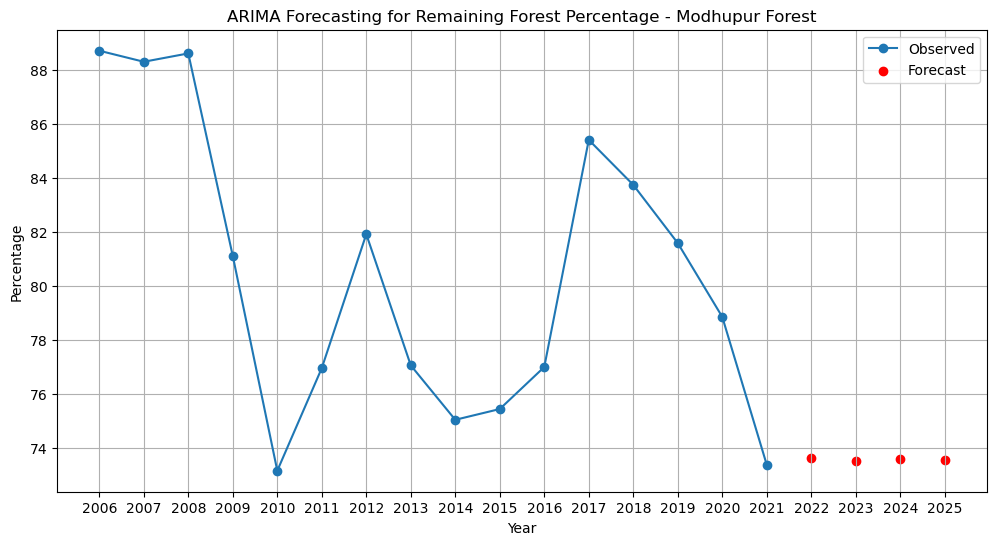

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Load the data
# Load the data
data = {
    'Year': ['2006-2007', '2007-2008', '2008-2009', '2009-2010', '2010-2011', '2011-2012',
             '2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018',
             '2018-2019', '2019-2020', '2020-2021', '2021-2022'],
    'Non-Forest Percentage': [11.27, 11.68, 11.37, 18.89, 26.86, 23.05, 18.08, 22.95, 24.97,
                              24.57, 23.01, 14.58, 16.25, 18.41, 21.15, 26.64],
    'Remaining Forest Percentage': [88.73, 88.32, 88.63, 81.11, 73.14, 76.95, 81.92, 77.05, 75.03,
                                    75.43, 76.99, 85.42, 83.75, 81.59, 78.85, 73.36]
}

df = pd.DataFrame(data)
df['Year'] = df['Year'].apply(lambda x: int(x.split('-')[0]))
df.set_index('Year', inplace=True)

# Stationarity testing using Augmented Dickey-Fuller test
result = adfuller(df['Remaining Forest Percentage'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# If the data is not stationary, take the difference
if result[1] > 0.05:
    df_diff = df.diff().dropna()
    print('Taking difference to achieve stationarity.')
else:
    df_diff = df.copy()

# Model fitting
model = ARIMA(df['Remaining Forest Percentage'], order=(1, 1, 1))  # Example order, you may need to adjust
results = model.fit()

# Forecasting for the years 2022, 2023, 2024, and 2025
future_years = [2022, 2023, 2024, 2025]
forecast_values = results.get_forecast(steps=len(future_years)).predicted_mean

# Extend the time index for the forecasted years
df_forecast = df.copy()
df_forecast = df_forecast.append(pd.DataFrame(index=future_years))  # Extend the time index for the forecasted years
df_forecast.loc[future_years, 'Remaining Forest Percentage'] = forecast_values

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_forecast.index, df_forecast['Remaining Forest Percentage'], label='Observed', marker='o')
plt.scatter(future_years, forecast_values, color='red', label='Forecast', marker='o')
plt.title('ARIMA Forecasting for Remaining Forest Percentage - Modhupur Forest')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.xticks(df_forecast.index)  # Set x-axis ticks to match the index
plt.legend()
plt.grid(True)
plt.show()


ADF Statistic: -3.3421889553902444
p-value: 0.013094780125644008
Critical Values: {'1%': -4.473135048010974, '5%': -3.28988060356653, '10%': -2.7723823456790124}


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\u2277809\AppData\Local\Temp\ipykernel_29440\2154423788.py:45: FutureWarning: The frame.append method is deprecated and will be removed from

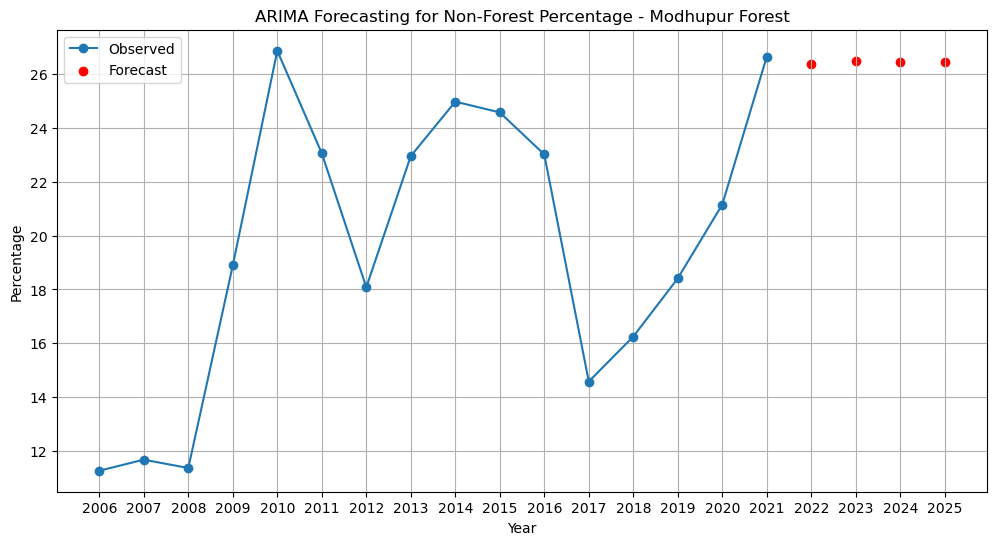

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Load the data
data = {
    'Year': ['2006-2007', '2007-2008', '2008-2009', '2009-2010', '2010-2011', '2011-2012',
             '2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018',
             '2018-2019', '2019-2020', '2020-2021', '2021-2022'],
    'Non-Forest Percentage': [11.27, 11.68, 11.37, 18.89, 26.86, 23.05, 18.08, 22.95, 24.97,
                              24.57, 23.01, 14.58, 16.25, 18.41, 21.15, 26.64],
    'Remaining Forest Percentage': [88.73, 88.32, 88.63, 81.11, 73.14, 76.95, 81.92, 77.05, 75.03,
                                    75.43, 76.99, 85.42, 83.75, 81.59, 78.85, 73.36]
}

df = pd.DataFrame(data)
df['Year'] = df['Year'].apply(lambda x: int(x.split('-')[0]))
df.set_index('Year', inplace=True)

# Stationarity testing using Augmented Dickey-Fuller test
result = adfuller(df['Non-Forest Percentage'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# If the data is not stationary, take the difference
if result[1] > 0.05:
    df_diff = df.diff().dropna()
    print('Taking difference to achieve stationarity.')
else:
    df_diff = df.copy()

# Model fitting
model = ARIMA(df['Non-Forest Percentage'], order=(1, 1, 1))  # Example order, you may need to adjust
results = model.fit()

# Forecasting for the years 2023, 2024, and 2025
future_years = [2022, 2023, 2024, 2025]
forecast_values = results.get_forecast(steps=len(future_years)).predicted_mean

# Extend the time index for the forecasted years
df_forecast = df.copy()
df_forecast = df_forecast.append(pd.DataFrame(index=future_years))  # Extend the time index for the forecasted years
df_forecast.loc[future_years, 'Non-Forest Percentage'] = forecast_values

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_forecast.index, df_forecast['Non-Forest Percentage'], label='Observed', marker='o')
plt.scatter(future_years, forecast_values, color='red', label='Forecast', marker='o')
plt.title('ARIMA Forecasting for Non-Forest Percentage - Modhupur Forest')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.xticks(df_forecast.index)  # Set x-axis ticks to match the index
plt.legend()
plt.grid(True)
plt.show()
